In [2]:
# Make the cells wider in the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from importlib import reload
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import waveglow_model as model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import train as train_utils
import DataLoader as DL

In [94]:
# Load a model instead of training one
# Original file name with params: 
# waveglow_ncontextchannels-96_nflows-8_ngroup-48-nearlyevery-99-nearlysize-99-nlayers-8_dilations-[1, 1, 2, 2, 2, 2, 4, 4]_nchannels_96-kernelsize-3-lr-0.00100_seed-2019


# original file with better loss:
# waveglow_ncontextchannels-96_nflows-8_ngroup-48-nearlyevery-99-nearlysize-99-nlayers-8_dilations-[1, 1, 2, 2, 2, 2, 4, 4]_nchannels_96-kernelsize-3-lr-0.00100_seed-2019
# nctx-96_nflows-8_ngroup-48_nee-99_nes-99_nlayers-8_dilation-11222244_nchannels-96_kernel-3_lr-0.001

# file trained for even longer:
# waveglow_ncontextchannels-96_nflows-16_ngroup-96-nearlyevery-99-nearlysize-99-nlayers-4_dilations-1-1-2-2_nchannels_96-kernelsize-9-lr-0.00100_seed-2019

reload(train_utils)
net = model.WaveGlow(
    n_context_channels=96, 
    n_flows=16, 
    n_group=96, 
    n_early_every=99,
    n_early_size=99,
    n_layers=4,
    dilation_list=[1,1,2,2],
    n_channels=96,
    kernel_size=9, use_cuda=False);

net, iteration_num = train_utils.load_checkpoint("CHECKPOINTS_FROM_GCLOUD/waveglow_ncontextchannels-96_nflows-16_ngroup-96-nearlyevery-99-nearlysize-99-nlayers-4_dilations-1-1-2-2_nchannels_96-kernelsize-9-lr-0.00100_seed-2019/epoch-25_loss-0.0571", net, None)

Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Channels:  96
Loaded checkpoint 'CHECKPOINTS_FROM_GCLOUD/waveglow_ncontextchannels-96_nflows-16_ngroup-96-nearlyevery-99-nearlysize-99-nlayers-4_dilations-1-1-2-2_nchannels_96-kernelsize-9-lr-0.00100_seed-2019/epoch-25_loss-0.0571' (iteration 466)


#############
False
Channels:  12
Channels:  12
Channels:  12
Channels:  12
Channels:  12
Channels:  12
Channels:  12
Channels:  12
Channels:  12
Channels:  12
Channels:  12
Channels:  12
Epoch: 1/3
	Loss: 1.536
Epoch: 2/3
	Loss: 1.060
Epoch: 3/3
	Loss: 0.795


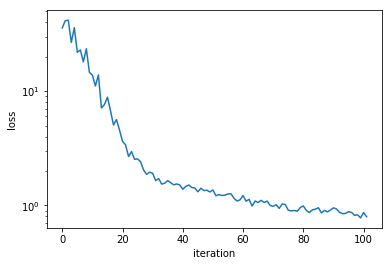

In [60]:
reload(train_utils)
reload(DL)
dataset = DL.DataLoader(rolling=True, train_f="./wind_power_data/wind_power_development.pickle")

params = [
    96, # n_context_channels
    12,  # n_flows
    12, # n_group
    99, # n_early_every
    2,  # n_early_size
    4,  # n_layers
    [1,2,4,8], # dilation_list
    96, # n_channels
    5,  # kernel_size
]
net = train_utils.training(
            dataset=dataset, 
            num_gpus=0, 
            output_directory='./train', 
            epochs=3, 
            learning_rate=1e-4, 
            batch_size=24, 
            checkpointing=False, 
            checkpoint_path="./checkpoints", 
            seed=2019, 
            params = params, 
            use_gpu=False, 
            gen_tests=False)


In [95]:
# Make some plots and stuff to see what the model is like
# Like, does it make realistic forecasts, and are the embedded samples actually normally distributed

# Took this line from DataLoader.py to see what the max number of test samps I could get at once was
# Currently, it evaluates to 365
max_test_samps = len(range(dataset.n, dataset.m_test-dataset.n+1, dataset.n))
num_samps = max_test_samps
orig_context, forecast = dataset.test_samples(num_contexts=num_samps)
torch_context = torch.FloatTensor(orig_context)
preds = net.generate(torch_context).numpy()
preds2 = net.generate(torch_context).numpy()
preds3 = net.generate(torch_context).numpy()
# preds4 = net.generate(torch_context).numpy()
# preds5 = net.generate(torch_context).numpy()


context = orig_context.squeeze()
print("context: ", context.shape)
print("forecast: ", forecast.shape)
print("preds: ", preds.shape)



context:  (365, 96)
forecast:  (365, 96)
preds:  (365, 96)


z:  (365, 96)
z max:  7.613703
z min:  -8.342089
z mean:  0.021625722
z std:  1.0744151


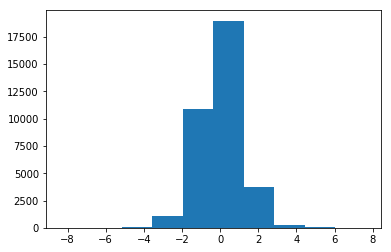

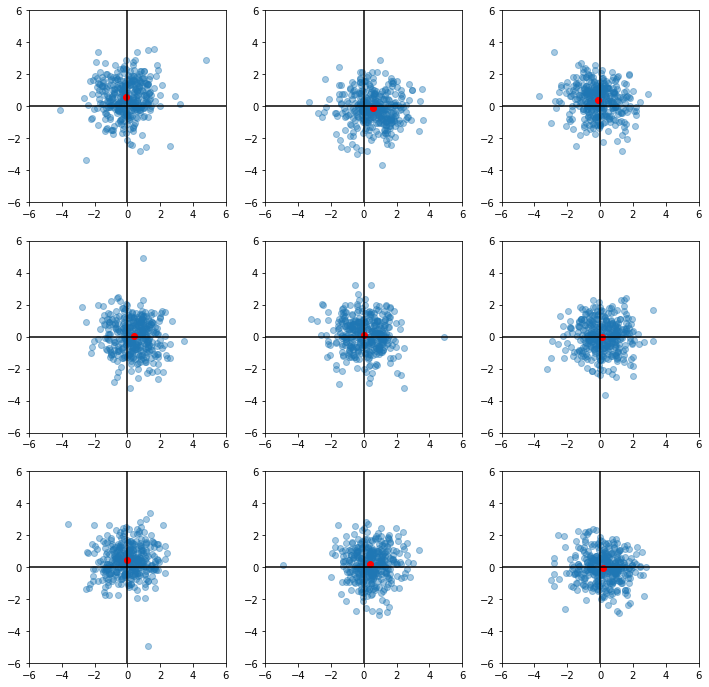

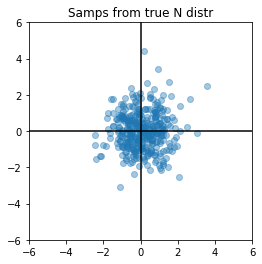

In [96]:
# Transform the test forecasts into the latent space, project them onto random planes
# see if they look like circularly distributed scatter plots (confirms the embedded
# points follow a spherical gaussian)
orig_z, log_s_list, log_det_w_list, early_assignment_shapes = net.forward(torch.FloatTensor(forecast), torch_context)
z = orig_z.detach().numpy().squeeze().reshape(orig_z.shape[0], -1)
print("z: ", z.shape)
print("z max: ", z.max())
print("z min: ", z.min())
print("z mean: ", z.mean())
print("z std: ", z.std())
plt.hist(z.reshape(-1))

# plot_rand_proj(z)
plot_rand_proj_new(z)

In [97]:
# Make sure if we transform these z's back into the original data space, they still match up roughly
torch_regen_forecast = net.generate(torch_context, latent_z=orig_z, early_assignment_shapes=early_assignment_shapes)
regen_forecast = torch_regen_forecast.numpy()
print("regen_forecast: ", regen_forecast.shape)
print("Max error in reconstruction: ", np.max(regen_forecast - forecast))

regen_forecast:  (365, 96)
Max error in reconstruction:  0.00018345642089823144


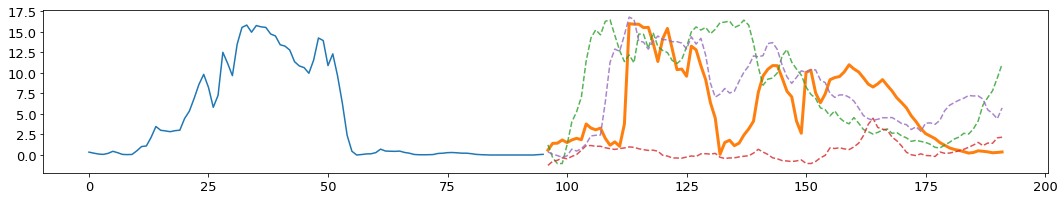

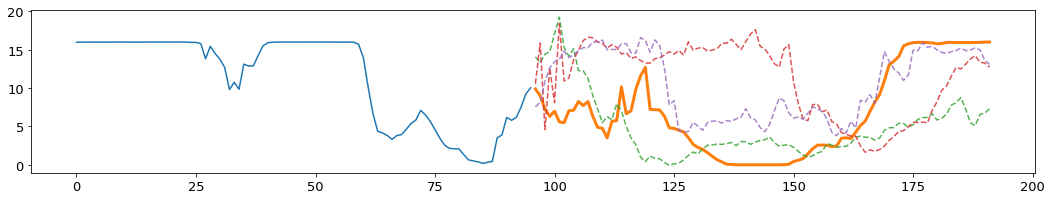

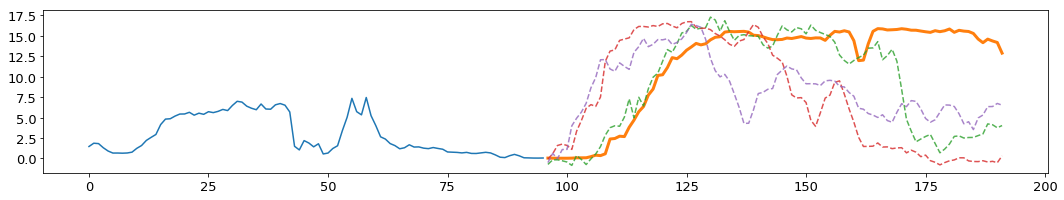

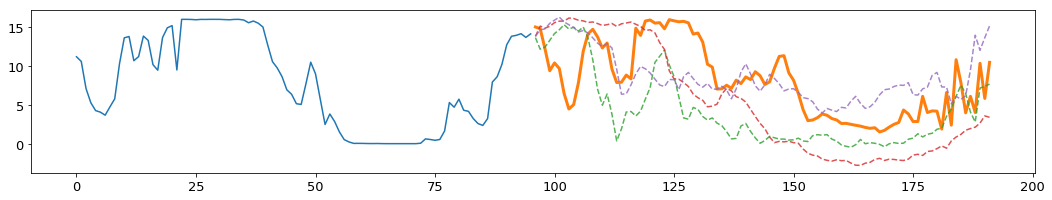

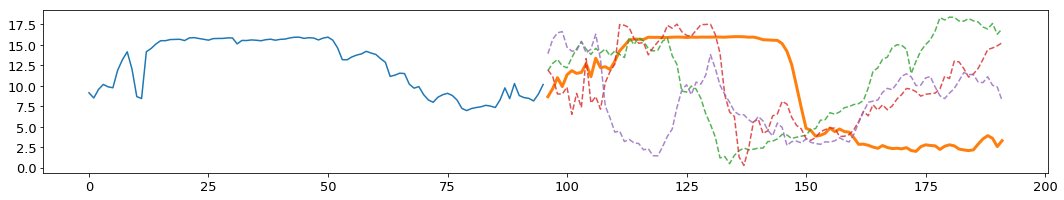

In [98]:
num_plot=5
for i in range(num_plot):
    rand_ind = np.random.randint(low=0, high=forecast.shape[0])
    ctx = context[rand_ind,:]
    fct = forecast[rand_ind,:]
    regen = regen_forecast[rand_ind,:]
    
    ridge_pred = ridge.predict(ctx.reshape(1,-1)).squeeze()
    
    pred = preds[rand_ind,:]
    pred2 = preds2[rand_ind, :]
    pred3 = preds3[rand_ind, :]
    pred4 = preds4[rand_ind, :]
    pred5 = preds5[rand_ind, :]
    plt.figure(figsize=(18,3))
    plt.plot(range(len(ctx)), ctx, label="Context")
    plt.plot(range(len(ctx), len(ctx)+len(fct)), fct, label="True", linewidth=3)
#     plt.plot(range(len(ctx), len(ctx)+len(fct)), ridge_pred, label="Ridge", linewidth=2)
    alpha_val = 0.8
    plt.plot(range(len(ctx), len(ctx)+len(fct)), pred, '--', label="Scenarios", alpha=alpha_val)
    plt.plot(range(len(ctx), len(ctx)+len(fct)), pred2, '--', alpha=alpha_val)
    plt.plot(range(len(ctx), len(ctx)+len(fct)), pred3, '--', alpha=alpha_val)
#     plt.plot(range(len(ctx), len(ctx)+len(fct)), pred4, '--', label="Forecast")
#     plt.plot(range(len(ctx), len(ctx)+len(fct)), pred5, '--', label="Forecast")
    
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    
#     plt.legend(fontsize=13);

#     plt.plot(range(len(ctx), len(ctx)+len(fct)), regen, 'o', label="Regen")
    
    

In [6]:
def plot_rand_proj(data):
    ''' 
    Convenience function to plot 9 random projections of the data onto 2D planes
    Intention is to check if distr is truly spherical, since all projects should look like circles
    '''
    
    num_proj = 9
    ax_lim = 6 # to enforce all plots having same scaling
    data_dim = data.shape[1]
    
    if data_dim == 2:
        # No projection necessary, just plot it directly
        plt.figure(figsize=(4,4))
        plt.scatter(data[:,0], data[:,1], alpha=0.4)
        
        # Add axis lines and plot the empircal mean to see how well they match
        mu = np.mean(data, axis=1)
        plt.scatter(mu[0], mu[1], color="r")

        plt.axvline(0, color="black")
        plt.axhline(0, color="black")
        plt.xlim(-ax_lim, ax_lim)
        plt.ylim(-ax_lim, ax_lim)
        plt.title("Scatter plot of data")

    else:
        # Otherwise, project onto random 2D planes and look at those
        plt.figure(figsize=(12,12))
        for i in range(num_proj):
            # Generate a random orthogonal matrix using QR
            Q = np.linalg.qr(np.random.randn(data_dim,data_dim))[0]
            # Pick two random directions and project the data onto them
            P = Q[np.random.choice(range(data_dim), size=2, replace=False), :]
            proj = P @ data.T

            plt.subplot(3,3,i+1)
            plt.scatter(proj[0,:], proj[1,:], alpha=.4)

            # Add axis lines and plot the empircal mean to see how well they match
            mu = np.mean(proj, axis=1)
            plt.scatter(mu[0], mu[1], color="r")

            plt.axvline(0, color="black")
            plt.axhline(0, color="black")
            plt.xlim(-ax_lim, ax_lim)
            plt.ylim(-ax_lim, ax_lim)

    # For comparison, also plot an example scatter plot from a true normal distribution
    samps = np.random.randn(2, data.shape[0])
    plt.figure(figsize=(4,4))
    plt.scatter(samps[0,:], samps[1,:], alpha=0.4)
    plt.axvline(0, color="black")
    plt.axhline(0, color="black")
    plt.xlim(-ax_lim, ax_lim)
    plt.ylim(-ax_lim, ax_lim)
    plt.title("Samps from true N distr");

In [7]:
def plot_rand_proj_new(data):
    ''' 
    Convenience function to plot 9 random projections of the data onto 2D planes
    Intention is to check if distr is truly spherical, since all projects should look like circles
    
    Difference from vanilla plot_rand_proj is that this guarantees each plane chosen for projection
    is perpendicualr to previous planes chosen
    '''
    
    num_proj = 9
    ax_lim = 6 # to enforce all plots having same scaling
    data_dim = data.shape[1]
    
    if data_dim == 2:
        # No projection necessary, just plot it directly
        plt.figure(figsize=(4,4))
        plt.scatter(data[:,0], data[:,1], alpha=0.4)
        
        # Add axis lines and plot the empircal mean to see how well they match
        mu = np.mean(data, axis=1)
        plt.scatter(mu[0], mu[1], color="r")

        plt.axvline(0, color="black")
        plt.axhline(0, color="black")
        plt.xlim(-ax_lim, ax_lim)
        plt.ylim(-ax_lim, ax_lim)
        plt.title("Scatter plot of data")

    else:
        # Otherwise, project onto random 2D planes and look at those
        plt.figure(figsize=(12,12))
        # Generate a random orthogonal matrix using QR
        Q = np.linalg.qr(np.random.randn(data_dim,data_dim))[0]
        for i in range(num_proj):    
            # Pick two unused columns from Q
            cols = [i*2, (i+1)*2]
            P = Q[cols, :]
            proj = P @ data.T

            plt.subplot(3,3,i+1)
            plt.scatter(proj[0,:], proj[1,:], alpha=.4)

            # Add axis lines and plot the empircal mean to see how well they match
            mu = np.mean(proj, axis=1)
            plt.scatter(mu[0], mu[1], color="r")

            plt.axvline(0, color="black")
            plt.axhline(0, color="black")
            plt.xlim(-ax_lim, ax_lim)
            plt.ylim(-ax_lim, ax_lim)

    # For comparison, also plot an example scatter plot from a true normal distribution
    samps = np.random.randn(2, data.shape[0])
    plt.figure(figsize=(4,4))
    plt.scatter(samps[0,:], samps[1,:], alpha=0.4)
    plt.axvline(0, color="black")
    plt.axhline(0, color="black")
    plt.xlim(-ax_lim, ax_lim)
    plt.ylim(-ax_lim, ax_lim)
    plt.title("Samps from true N distr");

In [32]:
# Fit a quick ridge regression model on the dev set to use as a baseline in forecasting
from sklearn.linear_model import RidgeCV
from time import time

# data = DL.DataLoader(rolling=True, train_f="./wind_power_data/wind_power_development.pickle").trainset
data = DL.DataLoader(rolling=True).trainset

# Trim the data for quick development
# data = data[-10000:]

n_all = data.shape[0]
n_feat = 96 # number of features used as input
n_horizon = 96 # number of steps into the future to predict
n_samps = n_all - (n_feat + n_horizon) + 1

# Create the X and y matrices
# X is shape (n_samples, n_features), so in this case (809, 96)
X = np.zeros((n_samps, n_feat))
y = np.zeros((n_samps, n_horizon))
for i in range(n_samps):
    x_start = i
    x_stop = x_start + n_feat
    X[i,:] = data[x_start:x_stop]

    y_start = x_stop
    y_stop = y_start + n_horizon
    y[i,:] = data[y_start:y_stop]
    

In [43]:
tic = time()
cv_folds = 5
alphas = np.logspace(-5, 5, 10)
ridge = RidgeCV(alphas=alphas, cv=cv_folds).fit(X,y)
print("Time taken to train Ridge with %i fold CV: %.0f sec" % ( cv_folds, time() - tic))

Time taken to train Ridge with 5 fold CV: 17 sec


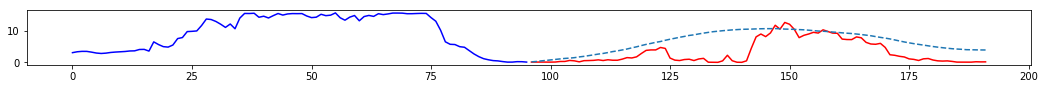

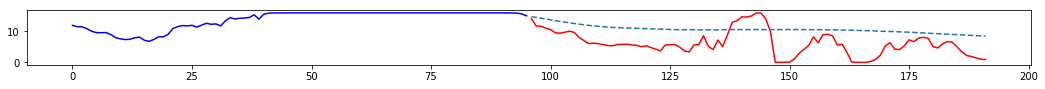

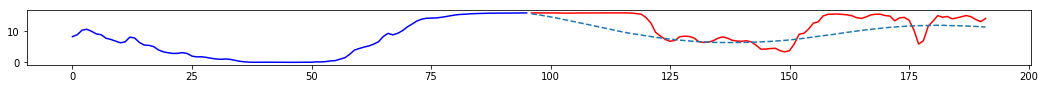

In [45]:
# Plot a few random predictions to make sure they're decent
num_plots = 3
for i in range(num_plots):
    plt.figure(figsize=(18,1))
    ind = np.random.randint(0, n_samps)
    plt.plot(range(n_feat), X[ind,:], color='blue')
    plt.plot(range(n_feat, n_feat+n_horizon), y[ind,:], color='red')
    plt.plot(range(n_feat, n_feat+n_horizon), ridge.predict(X[ind,:].reshape(1,-1)).squeeze(), '--')
    